<a href="https://colab.research.google.com/github/Rex-Chan99/Bitcoin_prediction/blob/main/Master_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas_ta
!pip install numpy==1.23.5
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=3b6ad989fa00ed8ddd3ac8b6c63956b345d05c7e22cd5bf4d9851746159ba730
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 58.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible

In [2]:
!git clone https://github.com/ArthurChan-1111/Bitcoin_prediction.git

%cd Bitcoin_prediction

import pandas as pd
import pandas_ta as ta
import csv
import numpy as np

btc_data = pd.read_csv('Bitcoin Historical Data.csv', on_bad_lines='skip', lineterminator='\n')
btc_data.tail(5)

Cloning into 'Bitcoin_prediction'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 103 (delta 36), reused 25 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (103/103), 7.32 MiB | 9.43 MiB/s, done.
Resolving deltas: 100% (36/36), done.
/content/Bitcoin_prediction


,Date,Price,Open,High,Low,Vol. ('000),Change %\r
4107,1/5/2014,1014.7,924.7,1029.9,911.4,21.37,9.74%\r
4108,1/4/2014,924.7,884.3,932.2,848.3,14.24,4.57%\r
4109,1/3/2014,884.3,856.9,888.2,839.4,9.71,3.19%\r
4110,1/2/2014,856.9,815.9,886.2,810.5,12.81,5.02%\r
4111,1/1/2014,815.9,805.9,829.9,771.0,10.76,1.24%


In [3]:
# Convert the dictionary to a DataFrame
btc_data = pd.DataFrame(btc_data)

# 1. Parse the "Date" column into datetime format
btc_data["Date"] = pd.to_datetime(btc_data["Date"], format="%m/%d/%Y")

# 2. Sort the data by date in ascending order
btc_data.sort_values(by="Date", ascending=True, inplace=True)

#3. Function to clean and convert volume data
def clean_volume(volume):
    if isinstance(volume, str):  # Check if the value is a string
        volume = volume.replace(',', '')  # Remove commas
        if 'B' in volume:  # If the value contains 'B' (billions)
            return float(volume.replace('B', '')) * 1_000_000_000
        elif 'M' in volume:  # If the value contains 'M' (millions)
            return float(volume.replace('M', '')) * 1_000_000
        elif 'K' in volume:  # If the value contains 'K' (thousands)
            return float(volume.replace('K', '')) * 1_000
        else:  # If no suffix is present, convert to float directly
            return float(volume)
    return np.nan  # Handle unexpected cases

# Apply the cleaning function to the volume column
btc_data["Volume"] = btc_data["Vol. ('000)"].apply(clean_volume)

# 4. Remove '%' from "Change %" and convert to numeric
btc_data.rename(columns={"Change %\r": "Change"}, inplace=True)
btc_data["Change"] = btc_data["Change"].str.replace("%", "").str.strip().astype(float)

In [4]:
# Calculate RSI, EMA, SMA, and MACD
btc_data["RSI_6"] = ta.rsi(btc_data["Price"], length=6)  # Relative Strength Index
btc_data["RSI_12"] = ta.rsi(btc_data["Price"], length=12)  # Relative Strength Index
btc_data["EMA_14"] = ta.ema(btc_data["Price"], length=14)  # Exponential Moving Average
btc_data["SMA_14"] = ta.sma(btc_data["Price"], length=14)  # Simple Moving Average

# Add On-Balance Volume (OBV)
btc_data["OBV"] = ta.obv(btc_data["Price"], btc_data["Volume"])

# Calculate MACD --------------------------------------------------------------------------------------
macd = ta.macd(btc_data["Price"], fast=12, slow=26, signal=9)
btc_data["MACD"] = macd["MACD_12_26_9"]
btc_data["MACD_Signal"] = macd["MACDs_12_26_9"]
btc_data["MACD_Hist"] = macd["MACDh_12_26_9"]

# Categorical MACD - Buy (1) and Sell (0) signals
btc_data["C_MACD"] = None  # Default to None (no signal)
btc_data.loc[
    (btc_data["MACD"] > btc_data["MACD_Signal"]) &
    (btc_data["MACD"].shift(1) <= btc_data["MACD_Signal"].shift(1)),
    "C_MACD"] = 1  # Buy signal # Detect Buy Signal (Crossover Up)
btc_data.loc[
    (btc_data["MACD"] <= btc_data["MACD_Signal"]) &
    (btc_data["MACD"].shift(1) > btc_data["MACD_Signal"].shift(1)),
    "C_MACD"] = 0  # Sell signal # Detect Sell Signal (Crossover Down)

# Calculate Bollinger Bands --------------------------------------------------------------------------------------
bbands = ta.bbands(btc_data["Price"], length=20, std=2)
btc_data["BB_Lower"] = bbands["BBL_20_2.0"]  # Lower Band
btc_data["BB_Middle"] = bbands["BBM_20_2.0"]  # Middle Band
btc_data["BB_Upper"] = bbands["BBU_20_2.0"]  # Upper Band
btc_data["BB_Percentage"] = ((btc_data["BB_Upper"] - btc_data["BB_Lower"]) / btc_data["BB_Middle"])

# Initialize C_BB column (default to no signal)
btc_data["C_BB"] = None

# Generate Buy and Sell Signals based on Bollinger Band crossovers
btc_data.loc[
    (btc_data["Price"] < btc_data["BB_Lower"]) & (btc_data["Price"].shift(1) >= btc_data["BB_Lower"].shift(1)),
    "C_BB"] = 1  # Buy signal (Price crosses below Lower Band)

btc_data.loc[
    (btc_data["Price"] > btc_data["BB_Upper"]) & (btc_data["Price"].shift(1) <= btc_data["BB_Upper"].shift(1)),
    "C_BB"] = 0  # Sell signal (Price crosses above Upper Band)

# Calculate ATR --------------------------------------------------------------------------------------
btc_data["ATR"] = ta.atr(btc_data["High"], btc_data["Low"], btc_data["Price"], length=14)

# Set Stop-Loss Levels (Example with Long Trade)
atr_multiplier = 2
btc_data["Stop_Loss_Long"] = btc_data["Price"] - (btc_data["ATR"] * atr_multiplier) #Stop-Loss for Buy (Long) Trade
btc_data["Stop_Loss_Short"] = btc_data["Price"] + (btc_data["ATR"] * atr_multiplier) #Stop-Loss for Sell (Short) Trade

# Calculate VWAP --------------------------------------------------------------------------------------
btc_data.set_index("Date", inplace=True) # Set the "Date" column as the index
btc_data["VWAP"] = ta.vwap(btc_data["High"], btc_data["Low"], btc_data["Price"], btc_data["Volume"])

# Initialize the "C_VWAP" column
btc_data["C_VWAP"] = None
# Generate buy and sell signals based on VWAP crossover
btc_data.loc[
    (btc_data["Price"] > btc_data["VWAP"]) & (btc_data["Price"].shift(1) <= btc_data["VWAP"].shift(1)),
    "C_VWAP"] = 1  # Buy signal (Price crosses above VWAP)

btc_data.loc[
    (btc_data["Price"] < btc_data["VWAP"]) & (btc_data["Price"].shift(1) >= btc_data["VWAP"].shift(1)),
    "C_VWAP"] = 0  # Sell signal (Price crosses below VWAP)
btc_data = btc_data.reset_index() #reset index

# Display the first few rows of the data with calculated indicators
btc_data.head(20)

,Date,Price,Open,High,Low,Vol. ('000),Change,Volume,RSI_6,RSI_12,...,BB_Lower,BB_Middle,BB_Upper,BB_Percentage,C_BB,ATR,Stop_Loss_Long,Stop_Loss_Short,VWAP,C_VWAP
0,2014-01-01,815.9,805.9,829.9,771.0,10.76,1.24,10.76,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,805.600000,None
1,2014-01-02,856.9,815.9,886.2,810.5,12.81,5.02,12.81,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,851.200000,None
2,2014-01-03,884.3,856.9,888.2,839.4,9.71,3.19,9.71,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,870.633333,None
3,2014-01-04,924.7,884.3,932.2,848.3,14.24,4.57,14.24,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,901.733333,None
4,2014-01-05,1014.7,924.7,1029.9,911.4,21.37,9.74,21.37,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,985.333333,None
5,2014-01-06,1012.7,1014.7,1093.4,964.7,23.08,-0.21,23.08,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,1023.600000,0
6,2014-01-07,879.9,1012.7,1044.0,879.8,22.67,-13.11,22.67,46.221295,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,934.566667,None
7,2014-01-08,938.8,879.9,966.9,858.9,14.1,6.70,14.10,58.073111,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,921.533333,1
8,2014-01-09,937.0,938.8,964.6,866.5,14.42,-0.20,14.42,57.607533,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,922.700000,None
9,2014-01-10,957.8,937.0,964.8,905.9,6.35,2.22,6.35,61.848816,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,942.833333,None


In [ ]:
# Calculate Bollinger Bands
bollinger_bands = ta.bbands(btc_data["Price"], length=20, std=2)
btc_data["BB_Upper"] = bollinger_bands["BBU_20_2.0"]
btc_data["BB_Middle"] = bollinger_bands["BBM_20_2.0"]
btc_data["BB_Lower"] = bollinger_bands["BBL_20_2.0"]

# Percentage difference between Bollinger Bands
btc_data["BB_Percentage"] = (
    (btc_data["BB_Upper"] - btc_data["BB_Lower"]) / btc_data["BB_Middle"])

In [ ]:
# Function to clean and convert volume data
def clean_volume(volume):
    if isinstance(volume, str):  # Check if the value is a string
        volume = volume.replace(',', '')  # Remove commas
        if 'B' in volume:  # If the value contains 'B' (billions)
            return float(volume.replace('B', '')) * 1_000_000_000
        elif 'M' in volume:  # If the value contains 'M' (millions)
            return float(volume.replace('M', '')) * 1_000_000
        elif 'K' in volume:  # If the value contains 'K' (thousands)
            return float(volume.replace('K', '')) * 1_000
        else:  # If no suffix is present, convert to float directly
            return float(volume)
    return np.nan  # Handle unexpected cases

# Apply the cleaning function to the volume column
btc_data["Volume"] = btc_data["Vol. ('000)"].apply(clean_volume)

In [ ]:
# Add On-Balance Volume (OBV)
btc_data["OBV"] = ta.obv(btc_data["Price"], btc_data["Volume"])

In [ ]:
# Day of the week (0=Monday, 6=Sunday)
btc_data["Day_of_Week"] = btc_data["Date"].dt.dayofweek

# Week of the year
btc_data["Week_of_Year"] = btc_data["Date"].dt.isocalendar().week

# Month of the year
btc_data["Month"] = btc_data["Date"].dt.month

# Quarter of the year
btc_data["Quarter"] = btc_data["Date"].dt.quarter

# Year
btc_data["Year"] = btc_data["Date"].dt.year

In [ ]:
# Support and Resistance Levels
btc_data["Support"] = btc_data["Low"].rolling(window=20).min()  # Lowest low in the past 20 days
btc_data["Resistance"] = btc_data["High"].rolling(window=20).max()  # Highest high in the past 20 days

In [ ]:
# Calculate the percentage price change over the next 7 days (Target Variable for Regression)
btc_data["Pct_Change"] = ((btc_data["Price"].shift(-7) - btc_data["Price"]) / btc_data["Price"]) * 100

In [ ]:
# Drop the original "Vol. ('000)" column
btc_data.drop(columns=["Vol. ('000)"], inplace=True)

# Reset index
btc_data.reset_index(drop=True, inplace=True)

In [ ]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           4112 non-null   datetime64[ns]
 1   Price          4112 non-null   float64       
 2   Open           4112 non-null   float64       
 3   High           4112 non-null   float64       
 4   Low            4112 non-null   float64       
      4112 non-null   object        
 6   RSI_6          4106 non-null   float64       
 7   RSI_12         4100 non-null   float64       
 8   EMA_14         4099 non-null   float64       
 9   SMA_14         4099 non-null   float64       
 10  MACD           4087 non-null   float64       
 11  MACD_Signal    4079 non-null   float64       
 12  MACD_Hist      4079 non-null   float64       
 13  BB_Upper       4093 non-null   float64       
 14  BB_Middle      4093 non-null   float64       
 15  BB_Lower       4093 non-null   floa

In [ ]:
btc_data.head()

,Date,Price,Open,High,Low,Change %\r,RSI_6,RSI_12,EMA_14,SMA_14,...,Volume,OBV,Day_of_Week,Week_of_Year,Month,Quarter,Year,Support,Resistance,Pct_Change
0,2014-01-01,815.9,805.9,829.9,771.0,1.24%,NaN,NaN,NaN,NaN,...,10.76,10.76,2,1,1,1,2014,NaN,NaN,15.063120
1,2014-01-02,856.9,815.9,886.2,810.5,5.02%\r,NaN,NaN,NaN,NaN,...,12.81,23.57,3,1,1,1,2014,NaN,NaN,9.347649
2,2014-01-03,884.3,856.9,888.2,839.4,3.19%\r,NaN,NaN,NaN,NaN,...,9.71,33.28,4,1,1,1,2014,NaN,NaN,8.311659
3,2014-01-04,924.7,884.3,932.2,848.3,4.57%\r,NaN,NaN,NaN,NaN,...,14.24,47.52,5,1,1,1,2014,NaN,NaN,8.716340
4,2014-01-05,1014.7,924.7,1029.9,911.4,9.74%\r,NaN,NaN,NaN,NaN,...,21.37,68.89,6,1,1,1,2014,NaN,NaN,-7.381492


In [ ]:
btc_data.tail()

,Date,Price,Open,High,Low,Change %\r,RSI_6,RSI_12,EMA_14,SMA_14,...,Volume,OBV,Day_of_Week,Week_of_Year,Month,Quarter,Year,Support,Resistance,Pct_Change
4107,2025-04-01,85164.2,82548.6,85506.2,82435.8,3.17%\r,55.110436,49.849551,84611.618769,85086.800000,...,66.72,-2.066536e+09,1,14,4,2,2025,79954.9,88740.2,NaN
4108,2025-04-02,82525.0,85166.0,88377.3,82358.9,-3.10%\r,39.571214,43.207951,84333.402933,84778.514286,...,104.05,-2.066536e+09,2,14,4,2,2025,80833.2,88740.2,NaN
4109,2025-04-03,83159.4,82522.6,83908.9,81313.8,0.77%\r,44.116403,45.125138,84176.869208,84703.607143,...,83.15,-2.066536e+09,3,14,4,2,2025,81171.3,88740.2,NaN
4110,2025-04-04,83866.7,83160.2,84704.1,81691.1,0.85%\r,49.225834,47.289371,84135.513314,84688.850000,...,91.54,-2.066536e+09,4,14,4,2,2025,81171.3,88740.2,NaN
4111,2025-04-05,83552.1,83876.0,84249.3,82384.4,-0.38%\r,46.935363,46.401387,84057.724872,84668.250000,...,32.71,-2.066536e+09,5,14,4,2,2025,81171.3,88740.2,NaN


In [ ]:
#draw the data from the fear and greed index
fear_and_greed_index = pd.read_csv('fear_and_greed_index.csv')
# rename the date column in fear_and_greed_index to Date
fear_and_greed_index.rename(columns={"date": "Date"}, inplace=True)
# convert the date column to datetime
fear_and_greed_index["Date"] = pd.to_datetime(fear_and_greed_index["Date"], format="%Y-%m-%d")
# dropping the timestamp, value_classification, time_until_update columns
fear_and_greed_index.drop(columns=["timestamp", "value_classification", "time_until_update"], inplace=True)
fear_and_greed_index.head()

,value,Date
0,34,2025-04-06
1,30,2025-04-05
2,28,2025-04-04
3,25,2025-04-03
4,44,2025-04-02


In [ ]:
# Join the two dataframes on the "Date" column, dropping
btc_data = btc_data.merge(fear_and_greed_index, on="Date", how="left")
btc_data.head()

,Date,Price,Open,High,Low,Change %\r,RSI_6,RSI_12,EMA_14,SMA_14,...,OBV,Day_of_Week,Week_of_Year,Month,Quarter,Year,Support,Resistance,Pct_Change,value
0,2014-01-01,815.9,805.9,829.9,771.0,1.24%,NaN,NaN,NaN,NaN,...,10.76,2,1,1,1,2014,NaN,NaN,15.063120,NaN
1,2014-01-02,856.9,815.9,886.2,810.5,5.02%\r,NaN,NaN,NaN,NaN,...,23.57,3,1,1,1,2014,NaN,NaN,9.347649,NaN
2,2014-01-03,884.3,856.9,888.2,839.4,3.19%\r,NaN,NaN,NaN,NaN,...,33.28,4,1,1,1,2014,NaN,NaN,8.311659,NaN
3,2014-01-04,924.7,884.3,932.2,848.3,4.57%\r,NaN,NaN,NaN,NaN,...,47.52,5,1,1,1,2014,NaN,NaN,8.716340,NaN
4,2014-01-05,1014.7,924.7,1029.9,911.4,9.74%\r,NaN,NaN,NaN,NaN,...,68.89,6,1,1,1,2014,NaN,NaN,-7.381492,NaN


In [ ]:
# rename the value column to Fear_and_Greed_Index
btc_data.rename(columns={"value": "Fear_and_Greed_Index"}, inplace=True)
# normalize the Fear_and_Greed_Index column
btc_data["Fear_and_Greed_Index"] = (btc_data["Fear_and_Greed_Index"] - btc_data["Fear_and_Greed_Index"].min()) / (btc_data["Fear_and_Greed_Index"].max() - btc_data["Fear_and_Greed_Index"].min())
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


In [ ]:
# Add two columns for extreme fear and extreme greed
btc_data["Extreme_Fear"] = np.where(btc_data["Fear_and_Greed_Index"] < 0.2, 1, 0)
btc_data["Extreme_Greed"] = np.where(btc_data["Fear_and_Greed_Index"] > 0.8, 1, 0)
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


In [ ]:
# Use 70 in RSI to classify overbought and 30 to classify oversold
btc_data["RSI_12_Overbought"] = np.where(btc_data["RSI_12"] > 70, 1, 0)
btc_data["RSI_12_Oversold"] = np.where(btc_data["RSI_12"] < 30, 1, 0)
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


In [ ]:
# Adding RSI_6 greater than RSI_12 to show bullish divergence and conversely
btc_data["RSI_Bullish_Divergence"] = np.where(btc_data["RSI_6"] > btc_data["RSI_12"], 1, 0)
btc_data["RSI_Bearish_Divergence"] = np.where(btc_data["RSI_6"] < btc_data["RSI_12"], 1, 0)
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


In [ ]:
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


In [ ]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    4112 non-null   datetime64[ns]
 1   Price                   4112 non-null   float64       
 2   Open                    4112 non-null   float64       
 3   High                    4112 non-null   float64       
 4   Low                     4112 non-null   float64       
               4112 non-null   object        
 6   RSI_6                   4106 non-null   float64       
 7   RSI_12                  4100 non-null   float64       
 8   EMA_14                  4099 non-null   float64       
 9   SMA_14                  4099 non-null   float64       
 10  MACD                    4087 non-null   float64       
 11  MACD_Signal             4079 non-null   float64       
 12  MACD_Hist               4079 non-null   float64       
 13  BB

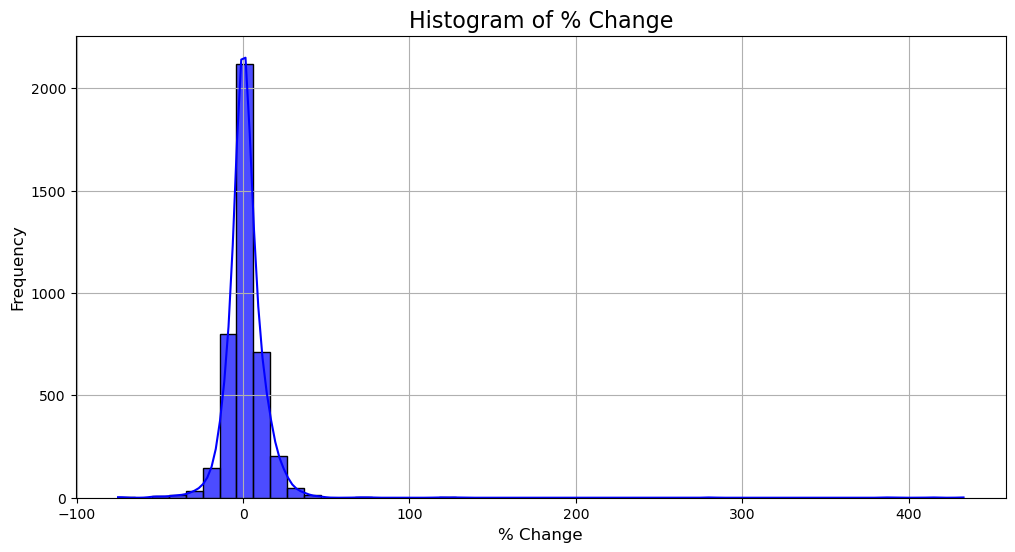

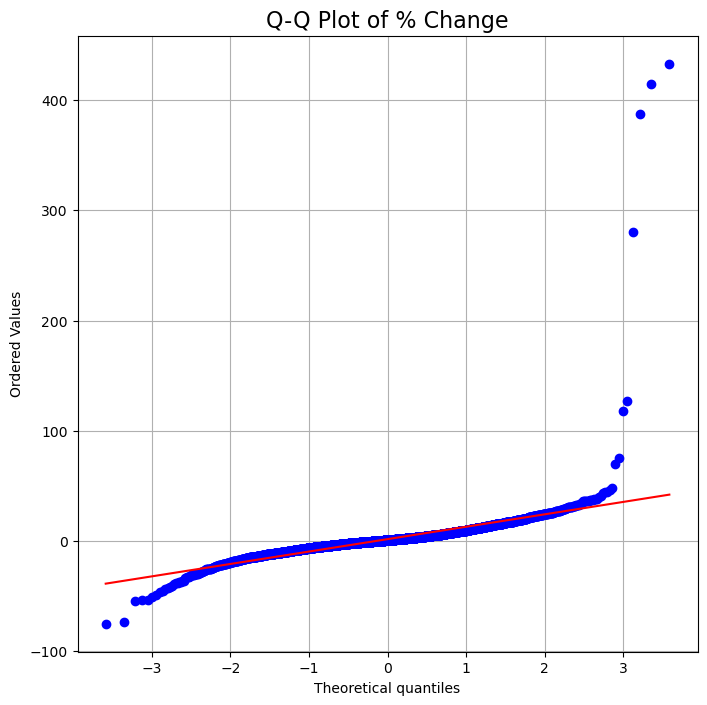

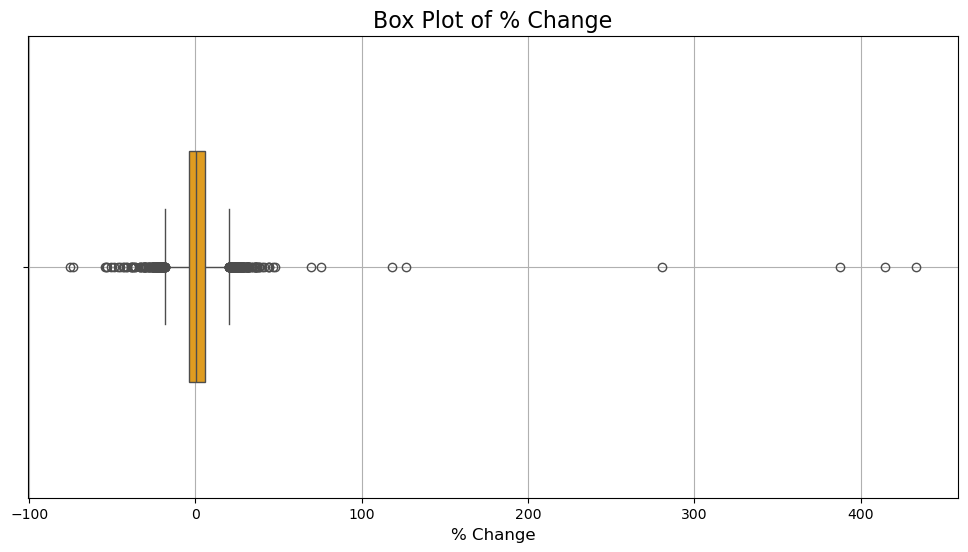

Lower Bound for Outliers: -18.22093825914128
Upper Bound for Outliers: 20.099138460649726
Number of Outliers: 272
Shapiro-Wilk Test Statistic: 0.5009, p-value: 0.0000
The data does not appear to be normally distributed (reject H0).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot

# Drop NaN values from the 'Pct_Change' column
btc_data = btc_data.dropna(subset=['Pct_Change'])

# Histogram to plot the distribution of 'Pct_Change'
plt.figure(figsize=(12, 6))
sns.histplot(btc_data['Pct_Change'], kde=True, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of % Change', fontsize=16)
plt.xlabel('% Change', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

# Q-Q Plot to visually check for normality
plt.figure(figsize=(8, 8))
probplot(btc_data['Pct_Change'], dist="norm", plot=plt)
plt.title('Q-Q Plot of % Change', fontsize=16)
plt.grid(True)
plt.show()

# Box Plot to check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=btc_data['Pct_Change'], color='orange', width=0.5)
plt.title('Box Plot of % Change', fontsize=16)
plt.xlabel('% Change', fontsize=12)
plt.grid(True)
plt.show()

# Identify Outliers based on the IQR (Interquartile Range) method
Q1 = btc_data['Pct_Change'].quantile(0.25)  # First quartile
Q3 = btc_data['Pct_Change'].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR  # Lower bound
upper_bound = Q3 + 1.5 * IQR  # Upper bound

print(f"Lower Bound for Outliers: {lower_bound}")
print(f"Upper Bound for Outliers: {upper_bound}")

# Filter outliers
outliers = btc_data[(btc_data['Pct_Change'] < lower_bound) | (btc_data['Pct_Change'] > upper_bound)]
print(f"Number of Outliers: {len(outliers)}")

# Shapiro-Wilk Test for normality
stat, p_value = shapiro(btc_data['Pct_Change'])
print(f"Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")

# Interpretation of the Shapiro-Wilk test result
if p_value > 0.05:
    print("The data appears to be normally distributed (fail to reject H0).")
else:
    print("The data does not appear to be normally distributed (reject H0).")

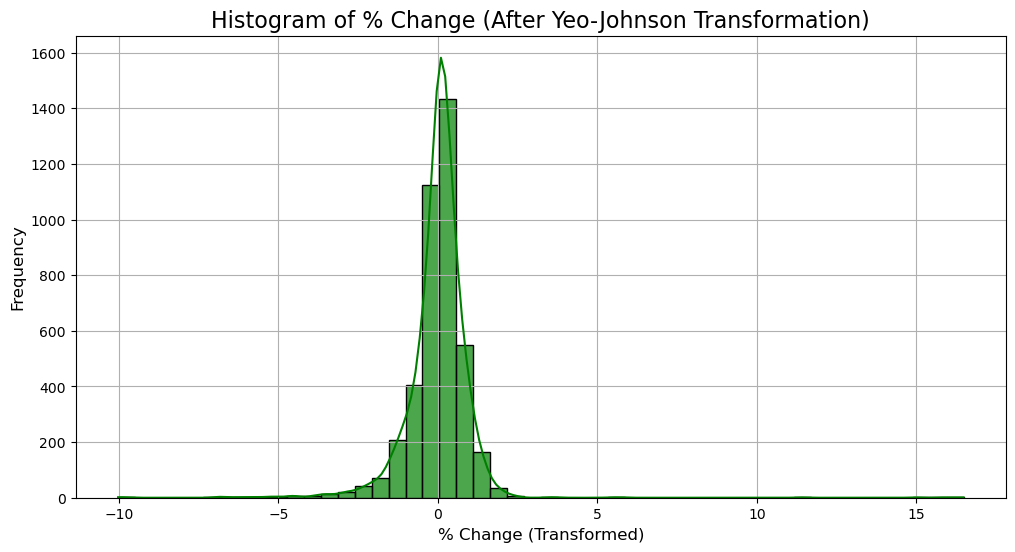

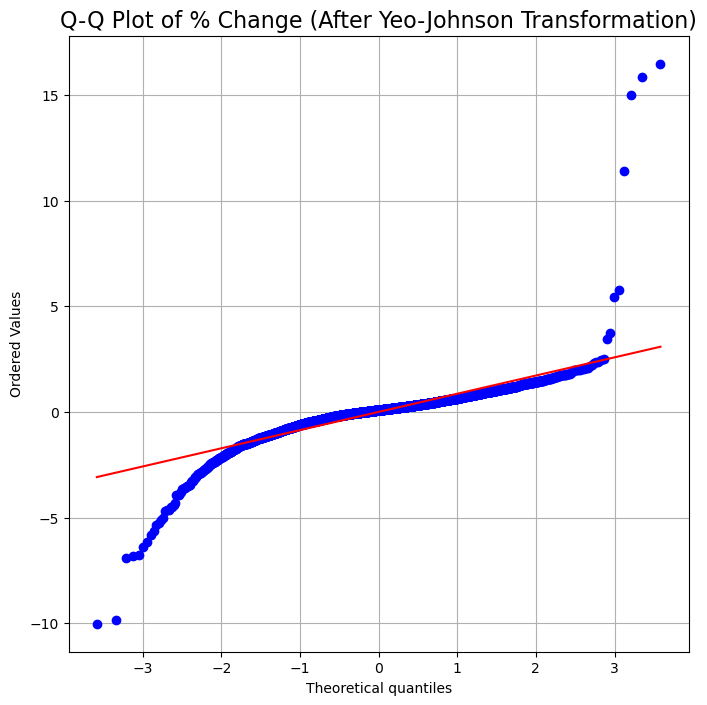

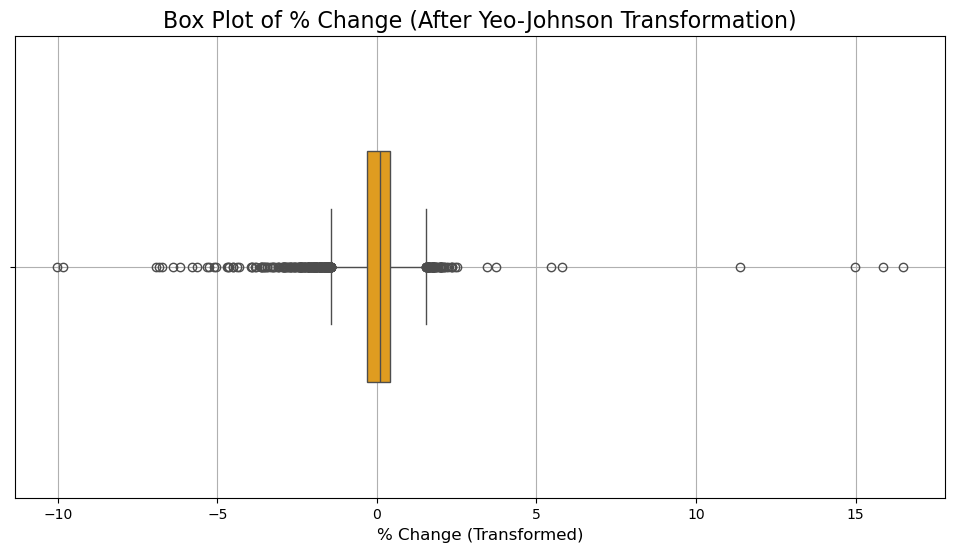

Shapiro-Wilk Test Statistic: 0.7413, p-value: 0.0000
Lower Bound for Outliers (Transformed): -1.428131344460079
Upper Bound for Outliers (Transformed): 1.5346348058134307
Number of Outliers (Transformed Data): 281


In [ ]:
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot, shapiro

# Initialize the Yeo-Johnson transformer
pt = PowerTransformer(method='yeo-johnson')

# Apply the transformation
btc_data['Pct_Change_YJ'] = pt.fit_transform(btc_data[['Pct_Change']])

# Plot the transformed data (Histogram)
plt.figure(figsize=(12, 6))
sns.histplot(btc_data['Pct_Change_YJ'], kde=True, bins=50, color='green', alpha=0.7)
plt.title('Histogram of % Change (After Yeo-Johnson Transformation)', fontsize=16)
plt.xlabel('% Change (Transformed)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

# Q-Q Plot for transformed data
plt.figure(figsize=(8, 8))
probplot(btc_data['Pct_Change_YJ'], dist="norm", plot=plt)
plt.title('Q-Q Plot of % Change (After Yeo-Johnson Transformation)', fontsize=16)
plt.grid(True)
plt.show()

# Box Plot to visualize outliers after transformation
plt.figure(figsize=(12, 6))
sns.boxplot(x=btc_data['Pct_Change_YJ'], color='orange', width=0.5)
plt.title('Box Plot of % Change (After Yeo-Johnson Transformation)', fontsize=16)
plt.xlabel('% Change (Transformed)', fontsize=12)
plt.grid(True)
plt.show()

# Run Shapiro-Wilk test for normality on transformed data
stat, p_value = shapiro(btc_data['Pct_Change_YJ'])
print(f"Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")

# Detect Outliers using the IQR method on the transformed data
Q1 = btc_data['Pct_Change_YJ'].quantile(0.25)  # First quartile
Q3 = btc_data['Pct_Change_YJ'].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR  # Lower bound
upper_bound = Q3 + 1.5 * IQR  # Upper bound

# Print the bounds for outliers
print(f"Lower Bound for Outliers (Transformed): {lower_bound}")
print(f"Upper Bound for Outliers (Transformed): {upper_bound}")

# Filter outliers
outliers = btc_data[(btc_data['Pct_Change_YJ'] < lower_bound) | (btc_data['Pct_Change_YJ'] > upper_bound)]
print(f"Number of Outliers (Transformed Data): {len(outliers)}")

# Optionally, cap or remove outliers
# Cap outliers (Winsorization)
btc_data['Pct_Change_YJ_Capped'] = btc_data['Pct_Change_YJ'].clip(lower=lower_bound, upper=upper_bound)

# Remove outliers
btc_data_no_outliers = btc_data[(btc_data['Pct_Change_YJ'] >= lower_bound) & (btc_data['Pct_Change_YJ'] <= upper_bound)]

In [ ]:
# Normalize the RSI and fear and greed index
btc_data["RSI_6"] = (btc_data["RSI_6"] - btc_data["RSI_6"].min()) / (btc_data["RSI_6"].max() - btc_data["RSI_6"].min())
btc_data["RSI_12"] = (btc_data["RSI_12"] - btc_data["RSI_12"].min()) / (btc_data["RSI_12"].max() - btc_data["RSI_12"].min())
btc_data["Fear_and_Greed_Index"] = (btc_data["Fear_and_Greed_Index"] - btc_data["Fear_and_Greed_Index"].min()) / (btc_data["Fear_and_Greed_Index"].max() - btc_data["Fear_and_Greed_Index"].min())
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4105,2019-08-15 00:26:39.610231296,2014-01-01 00:00:00,2016-10-23 00:00:00,2019-08-15 00:00:00,2022-06-06 00:00:00,2025-03-29 00:00:00,NaN
Price,4105.0,19946.154909,111.6,753.8,8887.8,30586.8,106157.2,24255.005578
Open,4105.0,19926.29296,111.6,753.8,8885.5,30533.6,106157.2,24237.091948
High,4105.0,20383.54687,160.1,769.0,9129.6,31383.8,109228.6,24751.994861
Low,4105.0,19440.265968,91.7,737.4,8669.3,30010.5,105350.6,23689.726507
RSI_6,4099.0,0.524958,0.0,0.380262,0.513272,0.670959,1.0,0.201504
RSI_12,4093.0,0.512427,0.0,0.393105,0.500775,0.622481,1.0,0.171456
EMA_14,4092.0,19872.694407,225.303492,737.233733,8926.9741,30440.325483,102629.881147,24075.733399
SMA_14,4092.0,19872.347247,221.585714,741.880357,8935.385714,30489.823214,103573.285714,24097.87344
MACD,4080.0,147.15842,-5068.338535,-113.511939,4.985499,307.805717,7024.867129,1133.589208


In [ ]:
import numpy as np
import pandas as pd

# Function to check for an upside trend before the cup
def has_upside_trend(prices, idx, lookback=7, min_increase=0.10):
    if idx < lookback:
        return False  # Not enough data for the lookback period
    recent_prices = prices[idx - lookback:idx]
    avg_increase = (recent_prices[-1] - recent_prices[0]) / recent_prices[0]
    return avg_increase >= min_increase

# Function to check for a valid cup formation
def is_valid_cup(prices, tolerance=0.03, min_drop=0.05):
    mid_idx = len(prices) // 2  # Middle index of the price array
    left_edge = prices[0]  # Left edge of the cup
    right_edge = prices[-1]  # Right edge of the cup
    bottom = min(prices)  # Bottom of the cup
    bottom_idx = np.argmin(prices)  # Index of the bottom

    # Ensure the bottom is at least `min_drop` lower than both edges
    if bottom >= left_edge * (1 - min_drop) or bottom >= right_edge * (1 - min_drop):
        return False

    # Ensure the left and right edges are within `tolerance` of each other
    if abs(left_edge - right_edge) / left_edge > tolerance:
        return False

    # Ensure symmetry: the left and right sides should have similar slopes
    left_slope = (bottom - left_edge) / bottom_idx
    right_slope = (right_edge - bottom) / (len(prices) - bottom_idx - 1)

    # Slopes must have opposite signs and similar magnitudes
    if not (abs(left_slope + right_slope) / abs(left_slope) < tolerance):
        return False

    return True

# Function to check for a valid handle formation
def is_valid_handle(prices, cup_bottom, cup_height, min_days=7, min_drop_ratio=0.30):
    handle_start = prices[0]
    handle_end = prices[-1]
    handle_drop = handle_start - handle_end
    required_drop = min_drop_ratio * (cup_height - cup_bottom)

    # Ensure the handle lasts at least `min_days` and drops by the required amount
    if len(prices) < min_days or handle_drop < required_drop:
        return False

    # Ensure the handle is a downtrend
    return all(prices[i] >= prices[i + 1] for i in range(len(prices) - 1))

# Function to check for a breakthrough after the handle
def has_breakthrough(prices, handle_end_idx):
    if handle_end_idx + 1 >= len(prices):
        return False  # Not enough data for breakthrough check
    handle_prices = prices[:handle_end_idx + 1]
    handle_slope = (handle_prices[-1] - handle_prices[0]) / len(handle_prices)

    # Check if the price breaks above the downward slope of the handle
    for i in range(handle_end_idx + 1, len(prices)):
        if prices[i] > handle_prices[-1] + handle_slope * (i - handle_end_idx):
            return True
    return False

# Detect cup and handle patterns in the price data
btc_data["Cup_Formation"] = 0
btc_data["Handle_Formation"] = 0
btc_data["Breakthrough"] = 0
prices = btc_data["Price"].values

for idx in range(len(btc_data) - 30):  # Ensure enough data for a 30-day window
    for period in range(14, 31):  # Check for periods between 14 and 30 days
        if idx + period < len(btc_data):
            cup_prices = prices[idx:idx + period]
            if has_upside_trend(prices, idx, lookback=7, min_increase=0.10) and is_valid_cup(cup_prices, tolerance=0.03, min_drop=0.05):
                cup_bottom = min(cup_prices)
                cup_height = max(cup_prices[0], cup_prices[-1])
                btc_data.loc[idx + period - 1, "Cup_Formation"] = 1  # Mark the rightmost position of the cup

                # Check for handle formation
                handle_start_idx = idx + period
                for handle_period in range(7, 15):  # Check for handle periods between 7 and 15 days
                    if handle_start_idx + handle_period < len(btc_data):
                        handle_prices = prices[handle_start_idx:handle_start_idx + handle_period]
                        if is_valid_handle(handle_prices, cup_bottom, cup_height, min_days=7, min_drop_ratio=0.30):
                            btc_data.loc[handle_start_idx + handle_period - 1, "Handle_Formation"] = 1

                            # Check for breakthrough
                            if has_breakthrough(prices, handle_start_idx + handle_period - 1):
                                btc_data.loc[handle_start_idx + handle_period - 1, "Breakthrough"] = 1
                            break

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Define a quadratic function for curve fitting
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

# Function to check for an upside trend before the cup
def has_upside_trend(prices, idx, lookback=21, min_increase=0.50):
    if idx < lookback:
        return False  # Not enough data for the lookback period
    recent_prices = prices[idx - lookback:idx]
    avg_increase = (recent_prices[-1] - recent_prices[0]) / recent_prices[0]
    return avg_increase >= min_increase

# Function to check for a valid cup formation with quadratic verification
def is_valid_cup(prices, tolerance=0.03, min_drop=0.05):
    x = np.arange(len(prices))  # X-axis values (time indices)
    left_edge = prices[0]  # Left edge of the cup
    right_edge = prices[-1]  # Right edge of the cup
    bottom = min(prices)  # Bottom of the cup
    bottom_idx = np.argmin(prices)  # Index of the bottom

    # Ensure the bottom is at least `min_drop` lower than both edges
    if bottom >= left_edge * (1 - min_drop) or bottom >= right_edge * (1 - min_drop):
        return False

    # Ensure the left and right edges are within `tolerance` of each other
    if abs(left_edge - right_edge) / left_edge > tolerance:
        return False

    # Fit a quadratic curve to the prices
    try:
        params, _ = curve_fit(quadratic, x, prices)
        a, b, c = params

        # Check if the curve is a U-shape (a > 0)
        if a <= 0:
            return False

        # Check if the minimum point of the quadratic curve aligns with the bottom
        min_idx = -b / (2 * a)
        if abs(min_idx - bottom_idx) > len(prices) * 0.1:  # Allow a 10% deviation
            return False
    except:
        return False

    return True

# Function to check for a valid handle formation
def is_valid_handle(prices, cup_bottom, cup_height, min_days=7, min_drop_ratio=0.30):
    handle_start = prices[0]
    handle_end = prices[-1]
    handle_drop = handle_start - handle_end
    required_drop = min_drop_ratio * (cup_height - cup_bottom)

    # Ensure the handle lasts at least `min_days` and drops by the required amount
    if len(prices) < min_days or handle_drop < required_drop:
        return False

    # Ensure the handle is a downtrend
    return all(prices[i] >= prices[i + 1] for i in range(len(prices) - 1))

# Function to check for a breakthrough after the handle
def has_breakthrough(prices, handle_end_idx):
    if handle_end_idx + 1 >= len(prices):
        return False  # Not enough data for breakthrough check
    handle_prices = prices[:handle_end_idx + 1]
    handle_slope = (handle_prices[-1] - handle_prices[0]) / len(handle_prices)

    # Check if the price breaks above the downward slope of the handle
    for i in range(handle_end_idx + 1, len(prices)):
        if prices[i] > handle_prices[-1] + handle_slope * (i - handle_end_idx):
            return True
    return False

btc_data["7MA"] = btc_data["Price"].rolling(window=7).mean()

# Detect cup and handle patterns in the price data
btc_data["Cup_Formation"] = 0
btc_data["Handle_Formation"] = 0
btc_data["Breakthrough"] = 0
btc_data["Cup_Start"] = np.nan
btc_data["Cup_End"] = np.nan
prices = btc_data["7MA"].values

for idx in range(len(btc_data) - 60):  # Ensure enough data for a 30-day window
    for period in range(14, 60):  # Check for periods between 14 and 60 days
        if idx + period < len(btc_data):
            cup_prices = prices[idx:idx + period]
            if has_upside_trend(prices, idx, lookback=7, min_increase=0.10) and is_valid_cup(cup_prices, tolerance=0.03, min_drop=0.05):
                cup_bottom = min(cup_prices)
                cup_height = max(cup_prices[0], cup_prices[-1])
                btc_data.loc[idx + period - 1, "Cup_Formation"] = 1  # Mark the rightmost position of the cup
                btc_data.loc[idx, "Cup_Start"] = 1  # Mark the starting point of the cup
                btc_data.loc[idx + period - 1, "Cup_End"] = 1  # Mark the ending point of the cup

                # Check for handle formation
                handle_start_idx = idx + period
                for handle_period in range(7, 15):  # Check for handle periods between 7 and 15 days
                    if handle_start_idx + handle_period < len(btc_data):
                        handle_prices = prices[handle_start_idx:handle_start_idx + handle_period]
                        if is_valid_handle(handle_prices, cup_bottom, cup_height, min_days=7, min_drop_ratio=0.30):
                            btc_data.loc[handle_start_idx + handle_period - 1, "Handle_Formation"] = 1

                            # Check and mark for breakthrough
                            if has_breakthrough(prices, handle_start_idx + handle_period - 1):
                                btc_data.loc[handle_start_idx + handle_period - 1, "Breakthrough"] = 1
                            break

In [ ]:
# no of count in cup formation
cup_count = btc_data["Cup_Formation"].sum()
# no of count in handle formation
handle_count = btc_data["Handle_Formation"].sum()
# no of count in breakthrough
breakthrough_count = btc_data["Breakthrough"].sum()
print(f"Number of Cup Formations Detected: {cup_count}")
print(f"Number of Handle Formations Detected: {handle_count}")
print(f"Number of Breakthroughs Detected: {breakthrough_count}")

Number of Cup Formations Detected: 116
Number of Handle Formations Detected: 20
Number of Breakthroughs Detected: 0


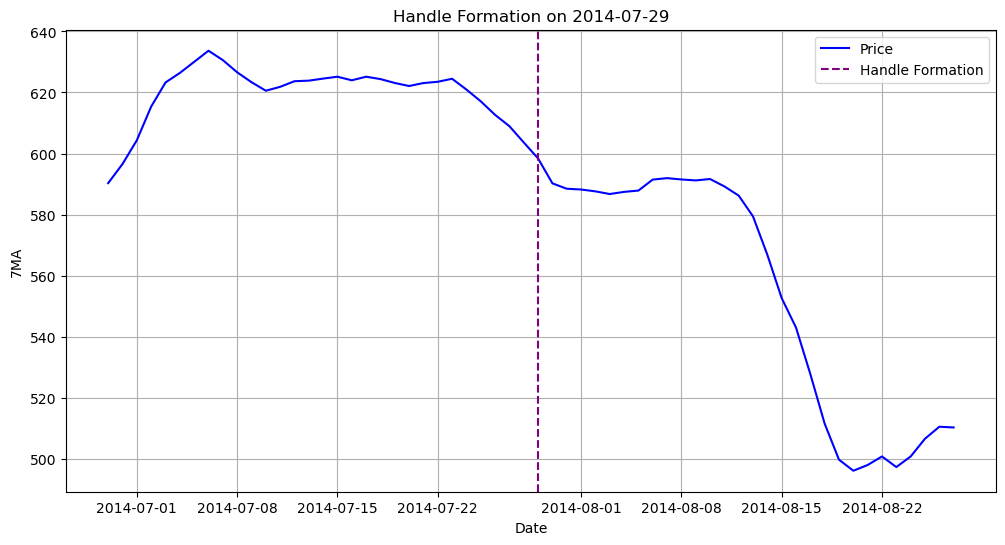

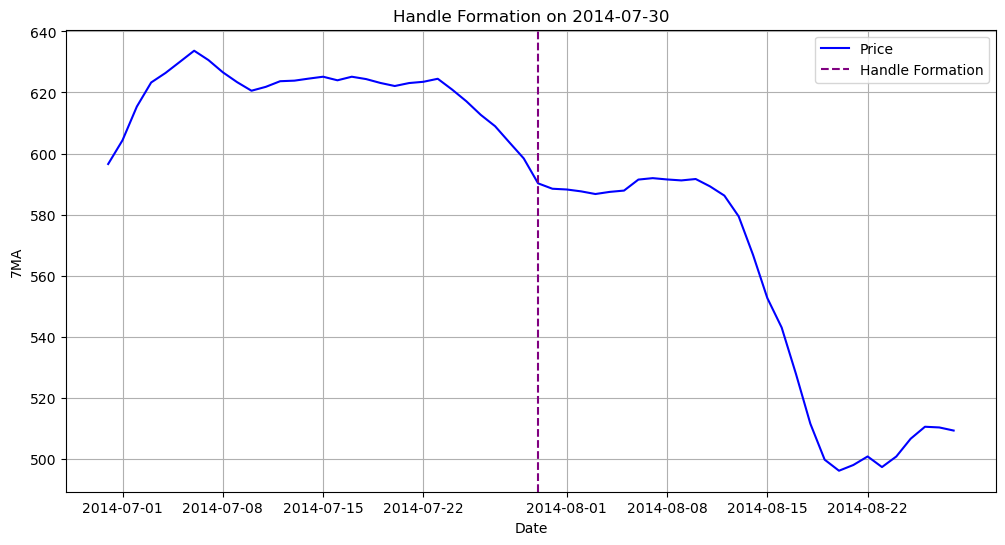

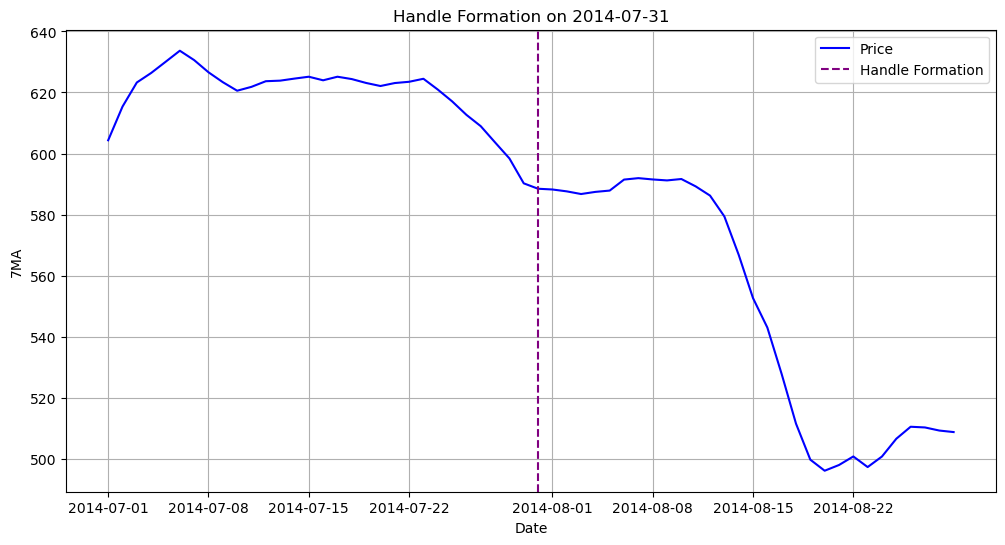

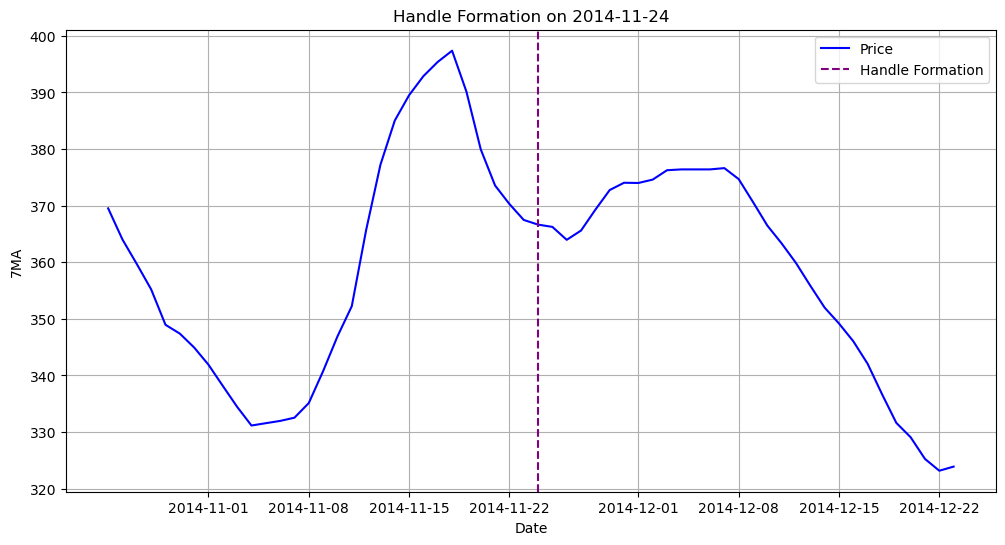

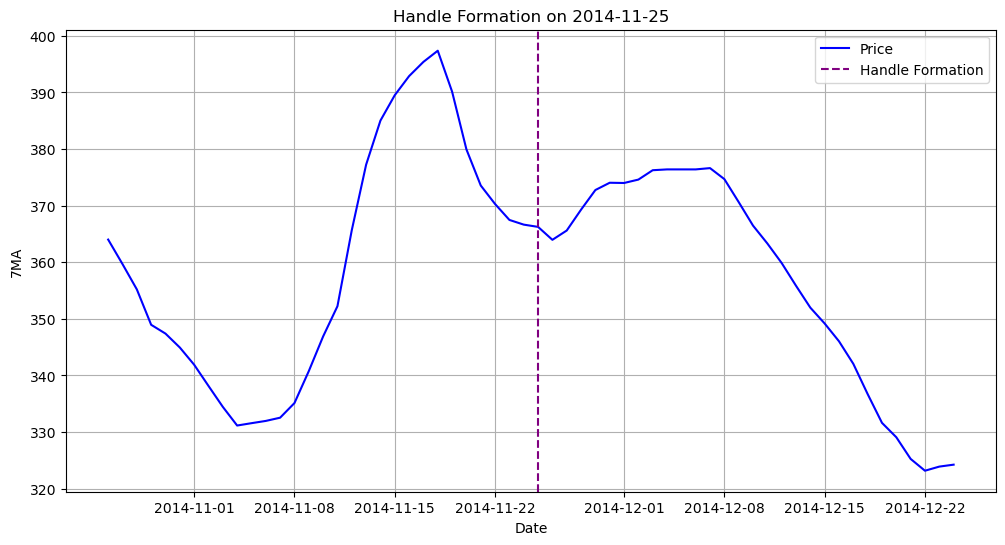

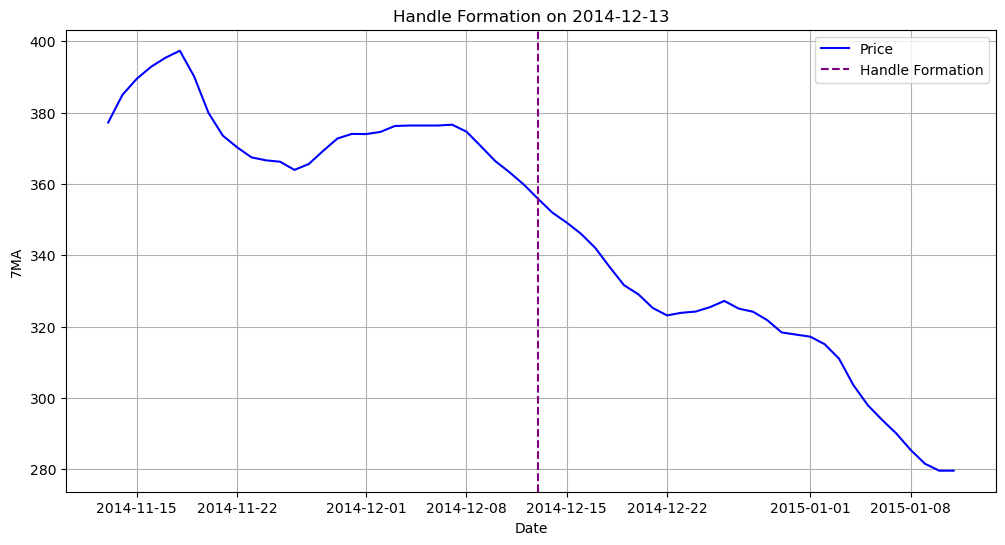

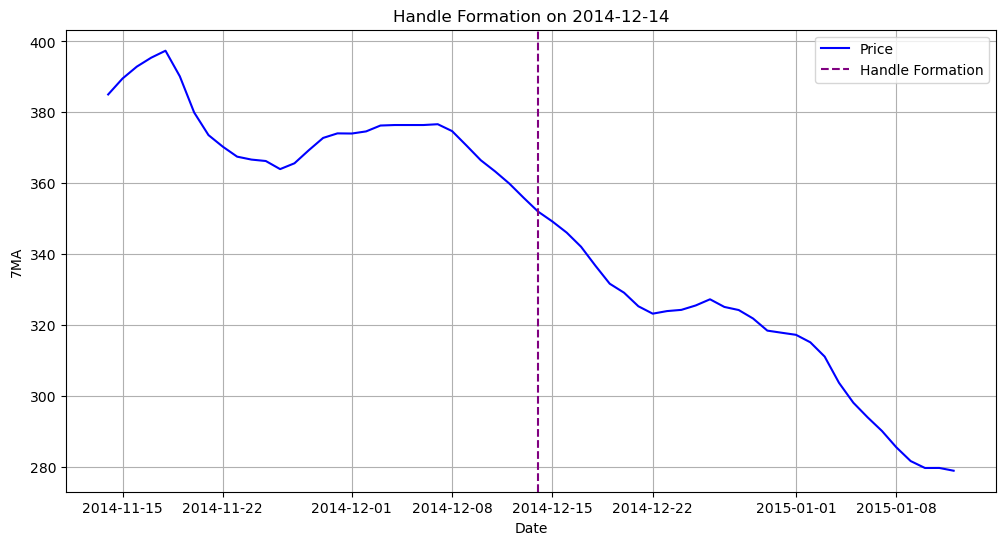

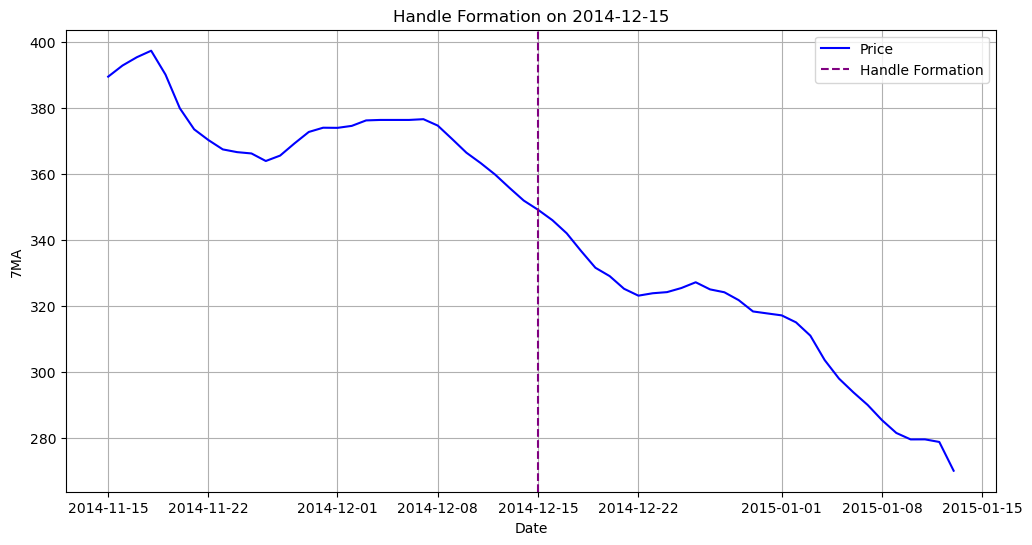

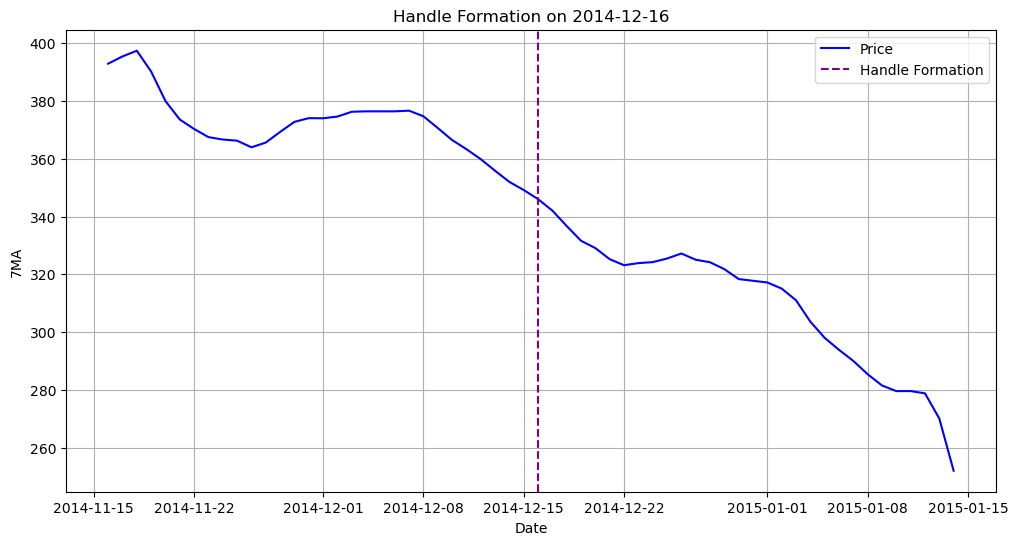

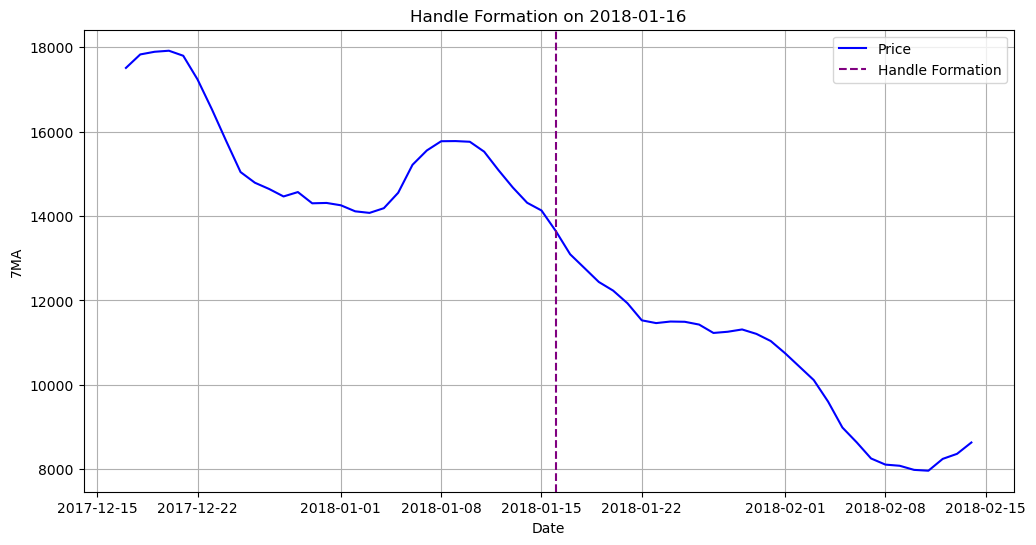

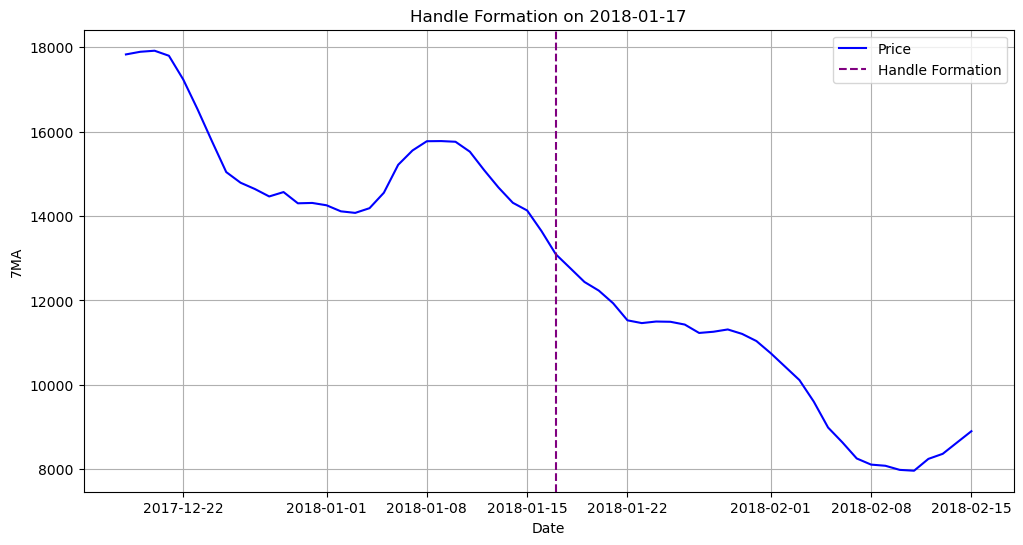

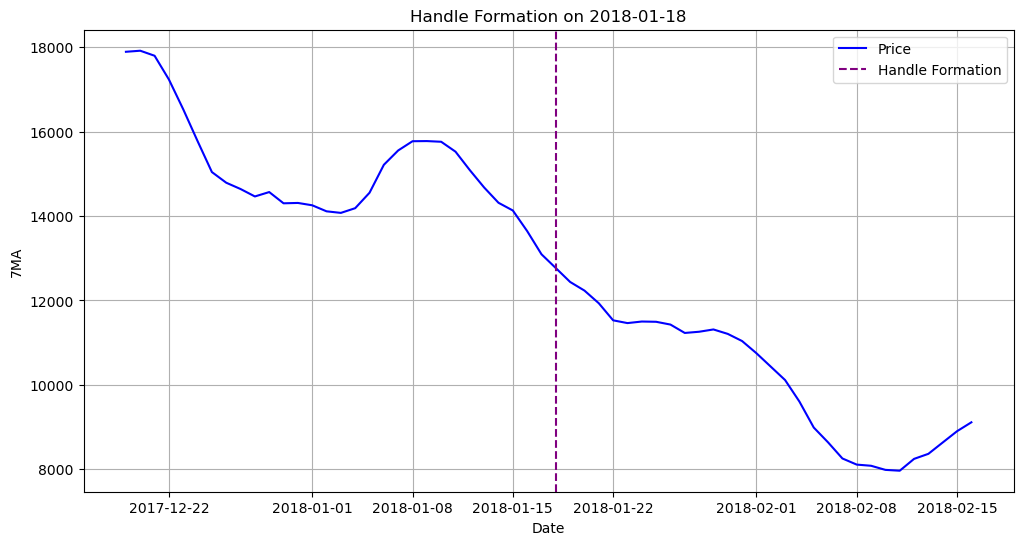

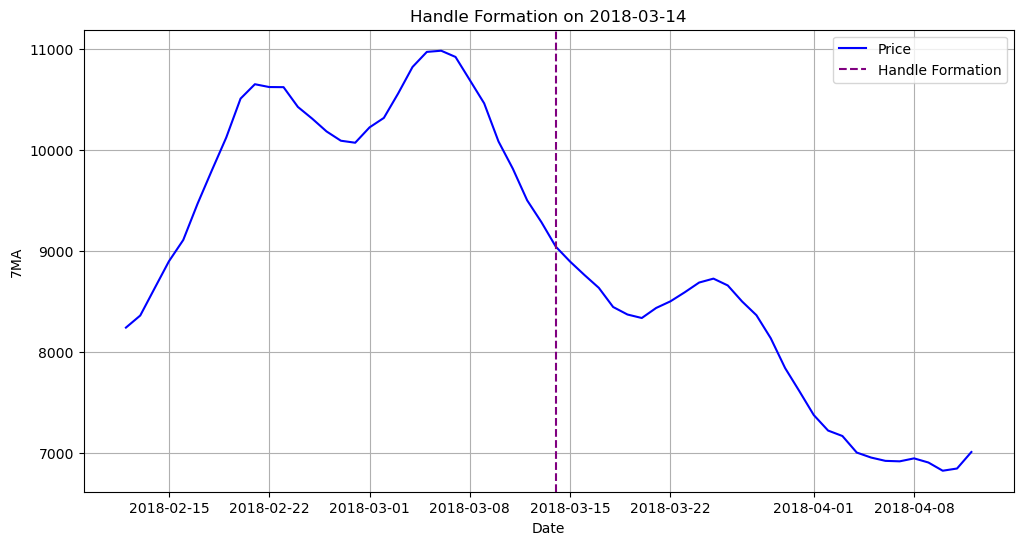

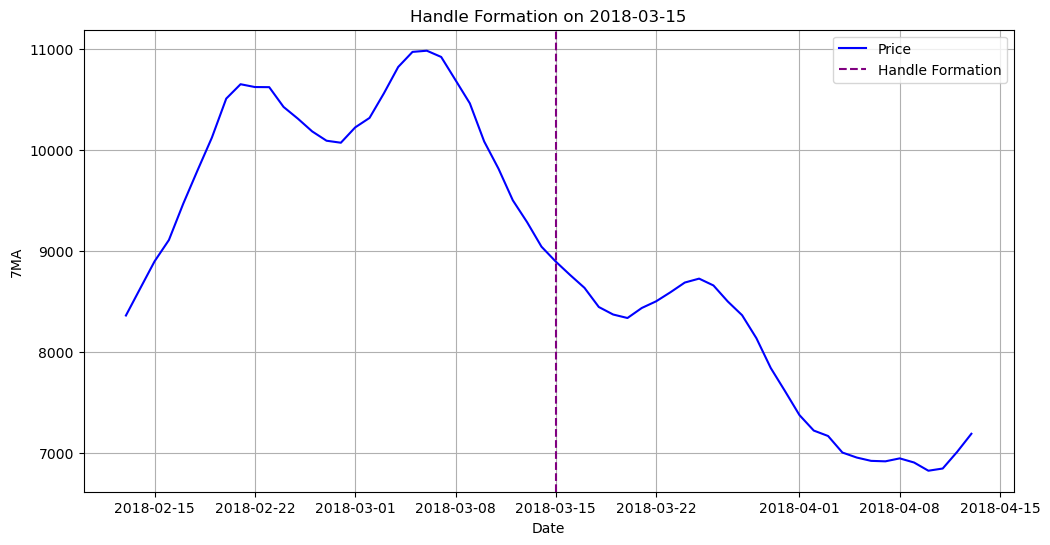

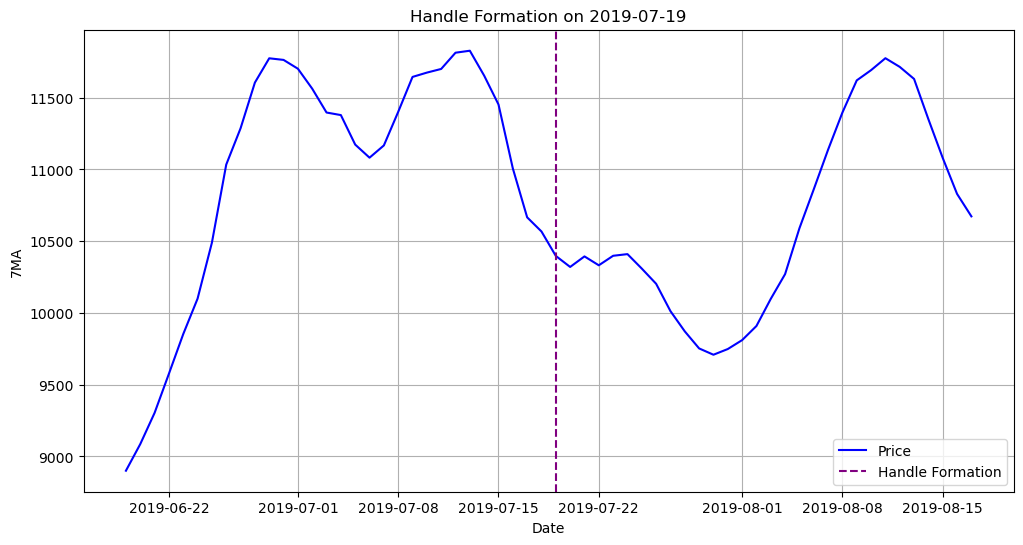

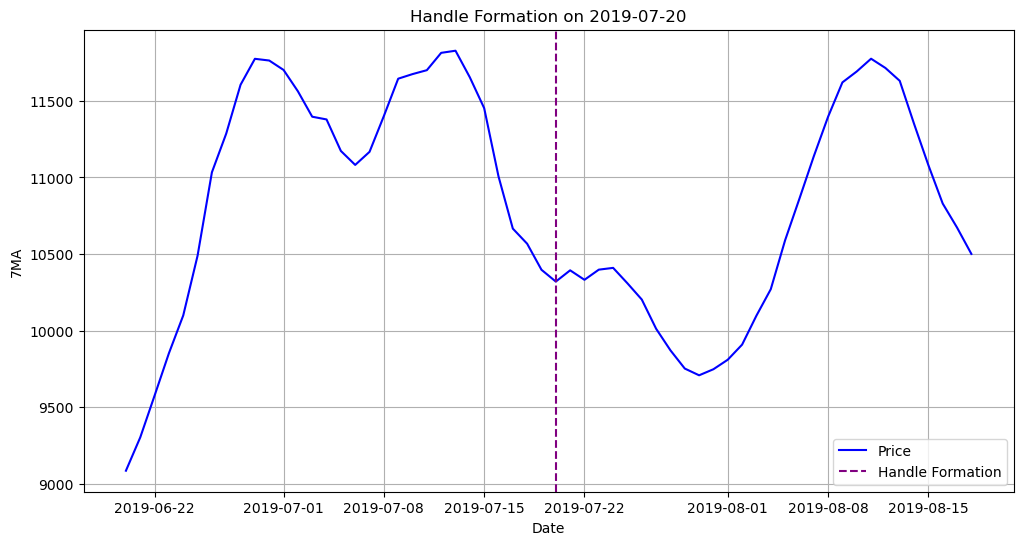

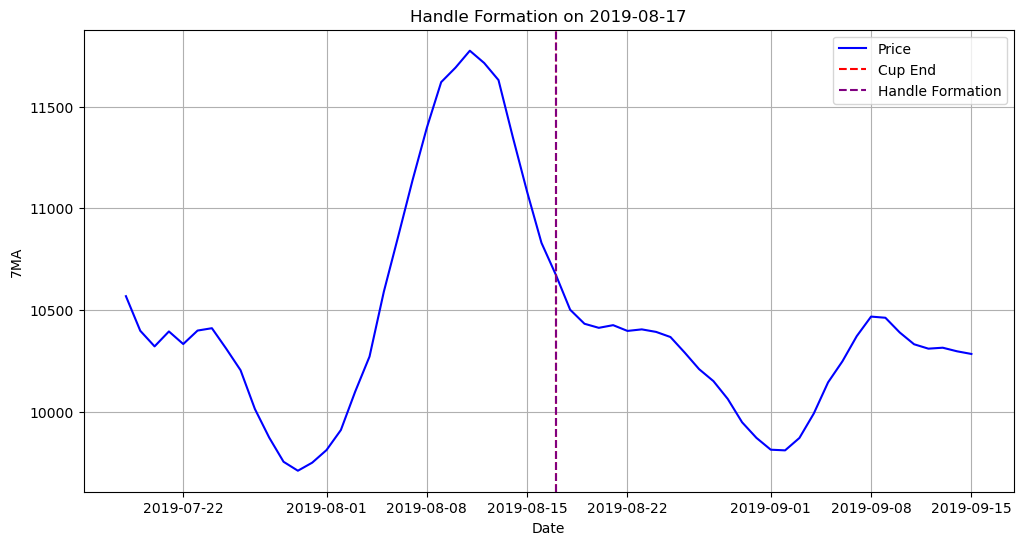

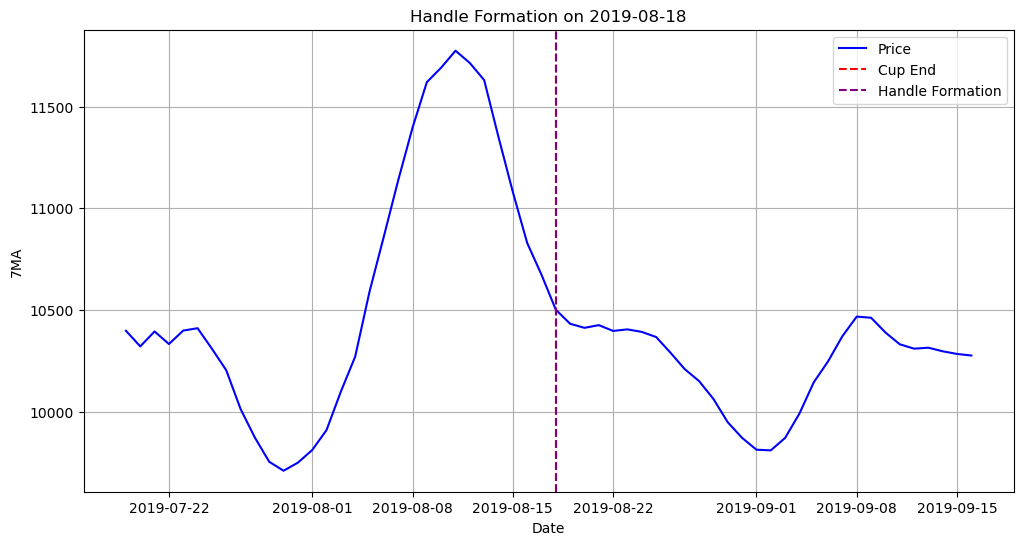

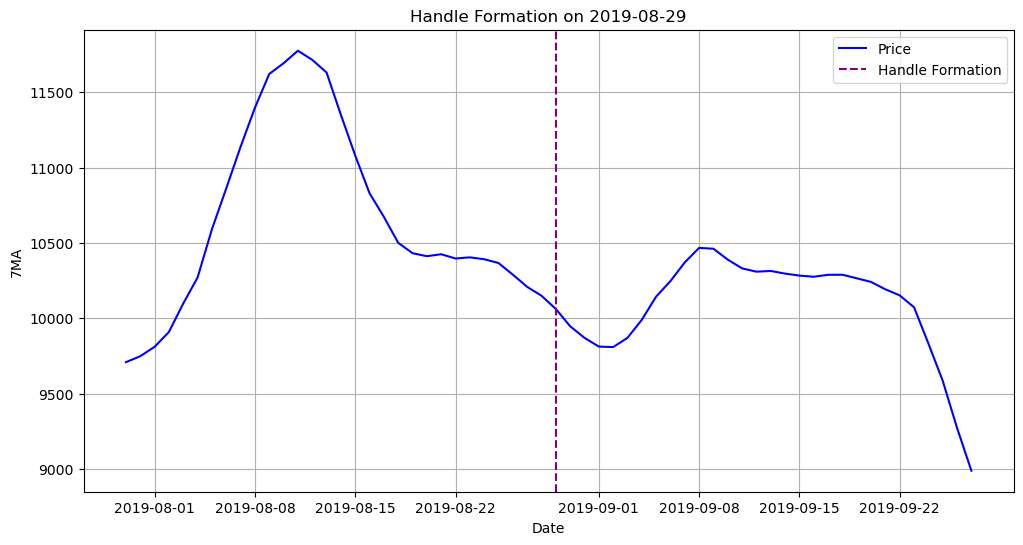

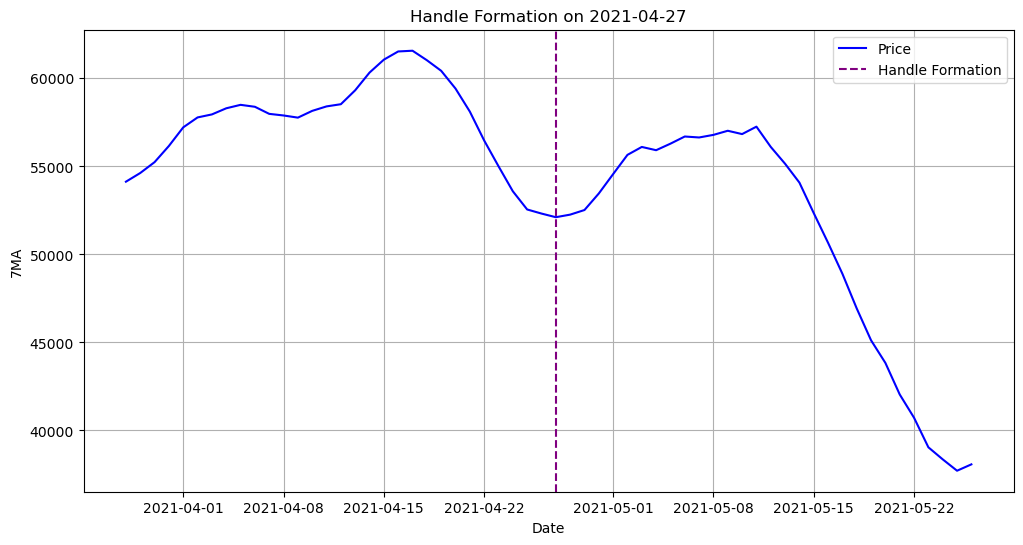

In [ ]:
import matplotlib.pyplot as plt

# Filter rows where Handle_Formation is detected
handle_signals = btc_data[btc_data["Handle_Formation"] == 1]

# Iterate through each handle formation
for index, row in handle_signals.iterrows():
    # Define the range for plotting (e.g., 30 days before and after the handle point)
    start_idx = max(index - 30, 0)
    end_idx = min(index + 30, len(btc_data) - 1)
    subset = btc_data.iloc[start_idx:end_idx]

    # Plot the price data
    plt.figure(figsize=(12, 6))
    plt.plot(subset["Date"], subset["7MA"], label="Price", color="blue")

    # Mark the cup edges
    if not pd.isna(row.get("Cup_Start")):
        plt.axvline(x=btc_data.loc[index - 30, "Date"], color="green", linestyle="--", label="Cup Start")
    if not pd.isna(row.get("Cup_End")):
        plt.axvline(x=btc_data.loc[index, "Date"], color="red", linestyle="--", label="Cup End")

    # Mark the handle formation point
    plt.axvline(x=row["Date"], color="purple", linestyle="--", label="Handle Formation")

    # Add title and labels
    plt.title(f"Handle Formation on {row['Date'].date()}")
    plt.xlabel("Date")
    plt.ylabel("7MA")
    plt.legend()
    plt.grid(True)
    plt.show()